100%|██████████| 500/500 [00:12<00:00, 38.55it/s]


Epoch: 0. Loss: 0.0686882734298706


100%|██████████| 500/500 [00:12<00:00, 39.72it/s]


Epoch: 1. Loss: 0.05275087431073189


100%|██████████| 500/500 [00:12<00:00, 39.57it/s]


Epoch: 2. Loss: 0.039241816848516464


100%|██████████| 500/500 [00:12<00:00, 39.75it/s]


Epoch: 3. Loss: 0.032369766384363174


100%|██████████| 500/500 [00:12<00:00, 39.86it/s]


Epoch: 4. Loss: 0.03164428099989891


100%|██████████| 500/500 [00:12<00:00, 40.08it/s]


Epoch: 5. Loss: 0.027066927403211594


100%|██████████| 500/500 [00:12<00:00, 40.15it/s]


Epoch: 6. Loss: 0.022924797609448433


100%|██████████| 500/500 [00:12<00:00, 40.24it/s]


Epoch: 7. Loss: 0.02029452659189701


100%|██████████| 500/500 [00:12<00:00, 40.08it/s]


Epoch: 8. Loss: 0.01557884830981493


100%|██████████| 500/500 [00:12<00:00, 40.11it/s]


Epoch: 9. Loss: 0.01314892154186964


100%|██████████| 500/500 [00:12<00:00, 40.29it/s]


Epoch: 10. Loss: 0.010866795666515827


100%|██████████| 500/500 [00:12<00:00, 40.42it/s]


Epoch: 11. Loss: 0.00921350996941328


100%|██████████| 500/500 [00:12<00:00, 40.32it/s]


Epoch: 12. Loss: 0.0052719032391905785


100%|██████████| 500/500 [00:12<00:00, 40.53it/s]


Epoch: 13. Loss: 0.004536182153970003


100%|██████████| 500/500 [00:12<00:00, 39.69it/s]


Epoch: 14. Loss: 0.002822751644998789


100%|██████████| 500/500 [00:12<00:00, 39.93it/s]


Epoch: 15. Loss: 0.00438563572242856


100%|██████████| 500/500 [00:12<00:00, 40.56it/s]


Epoch: 16. Loss: 0.002617662074044347


100%|██████████| 500/500 [00:12<00:00, 40.13it/s]


Epoch: 17. Loss: 0.004990804009139538


100%|██████████| 500/500 [00:12<00:00, 40.27it/s]


Epoch: 18. Loss: 0.004919934552162886


100%|██████████| 500/500 [00:12<00:00, 39.94it/s]

Epoch: 19. Loss: 0.0016139758517965674
Test Accuracy:  0.78


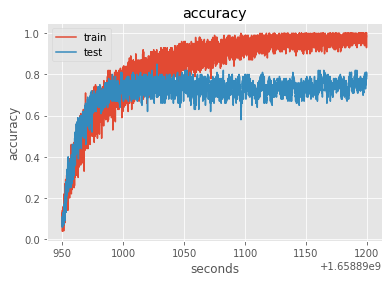

In [23]:
"""
This is a starter file to get you going. You may also include other files if you feel it's necessary.

Make sure to follow the code convention described here:
https://github.com/UWARG/computer-vision-python/blob/main/README.md#naming-and-typing-conventions

Hints:
* The internet is your friend! Don't be afraid to search for tutorials/intros/etc.
* We suggest using a convolutional neural network.
* TensorFlow Keras has the CIFAR-10 dataset as a module, so you don't need to manually download and unpack it.
"""

# Import whatever libraries/modules you need

from ast import arg
from matplotlib import style
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from re import L
from zmq import device

# Your working code here

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            #convolutional layers, 1 input and kernel size of 3
            nn.Conv2d(1, 16, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #maxpooling function emphasizes the important parts with a window of 2

            nn.Conv2d(32, 64, kernel_size=3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            #flatten to run through linear layers
            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            #10 classes to output through
            nn.Linear(512, 10)
        )
    def forward(self, data):
        return self.network(data)

        

def organize_data():
    #manage data from Tf dataset
    RGB_TO_GREY = [0.299, 0.587, 0.114]
    PIXEL_VALUE = 255.0
    #load CIFAR10 data set into np arrays
    (xTrain, yTrain), (xTest, yTest) = tf.keras.datasets.cifar10.load_data()
    #grey scale
    xTrain = np.dot(xTrain, RGB_TO_GREY)
    #conver to tensor
    xTrain = torch.Tensor(xTrain) 
    #convert to decimal values from 0-1
    xTrain = xTrain/PIXEL_VALUE
    #repeat for test set
    xTest = np.dot(xTest, RGB_TO_GREY)
    xTest = torch.Tensor(xTest) 
    xTest = xTest/PIXEL_VALUE
    #convert to tensor
    yTrain = torch.Tensor(yTrain)
    yTest = torch.Tensor(yTest)
    #make a new tensor of correct dimensions to input both images and labels into loss function
    ytrain = torch.zeros(len(xTrain), 10)
    ytest = torch.zeros(len(xTest), 10)
    #input correct value into correct index value for entire tensor
    for i in range(len(xTrain)):
        ytrain[i][(yTrain[i] - 1).long()] = 1.0
    for i in range(len(xTest)):
        ytest[i][(yTest[i] - 1).long()] = 1.0
    yTrain = ytrain
    yTest = ytest
    return xTrain, yTrain, xTest, yTest

def select_device():
    #choose device if you can use nvidea gpu
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

def train(net, xTrain, yTrain, xTest, yTest, device, loss_function, optimizer, EPOCHS, BATCH_SIZE, MODEL_NAME): 
    #use for graph later
    with open("model.log", "a") as f: 
        for epoch in range(EPOCHS):
            #use for loading bar
            for i in tqdm(range(0, len(xTrain), BATCH_SIZE)): 
                #array splice for each batch size
                #32, 32 because cnn can take 2d array
                x_batch = xTrain[i:i+BATCH_SIZE].view(-1, 1, 32, 32)
                y_batch = yTrain[i:i+BATCH_SIZE]
                #send to gpu
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                #get accuracy and loss through helper function
                acc, loss = fwd_pass(x_batch, y_batch, net, loss_function, optimizer, train = True)
                if i % 10 == 0:
                    #for the graph
                    val_acc, val_loss = test(xTest, yTest, net, loss_function, optimizer, device, size = 100)
                    f.write(f"{MODEL_NAME}, {round(time.time(), 3)}, {round(float(acc), 2)}, {round(float(loss), 4)}, {round(float(val_acc), 2)}, {round(float(val_loss), 4)}\n")
            print(f"Epoch: {epoch}. Loss: {loss}")

def batch_test(net, xTest, yTest, device, BATCH_SIZE): 
    with torch.no_grad():
        #test a batch of the test tensor
        x_batch = xTest[:BATCH_SIZE].view(-1, 1, 32, 32)
        y_batch = yTest[:BATCH_SIZE]
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #zero gradient
        net.zero_grad()
        #output of the cnn
        outputs = net(x_batch)
        #find matches of outputs and labels
        matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y_batch)]
        #find accuracy of matches
        acc = matches.count(True)/len(matches)
        print("Test Accuracy: ", round(acc, 3))

def fwd_pass(X, y, net, loss_function, optimizer, train = False):
    if train:
        #if we are training, zero the gradient
        net.zero_grad()
    #outputs of the cnn
    outputs = net(X)
    #find matches of outputs and labels
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
    #find accuracy of matches
    acc = matches.count(True)/len(matches)
    #run through loss function 
    loss = loss_function(outputs, y)
    if train: 
        #if we are training, optimize the network
        loss.backward()
        optimizer.step()
    return acc, loss

def test(xTest, yTest, net, loss_function, optimizer, device, size = 32):
    #test for points on the graph
    X, y = xTest[:size], yTest[:size]
    val_acc, val_loss = fwd_pass(X.view(-1, 1, 32, 32).to(device), y.to(device), net, loss_function, optimizer)
    return val_acc, val_loss


def create_acc_loss_graph(model_name, loss_or_acc):
    contents = open("model.log", "r").read().split("\n")
    times = []
    accuracies = []
    losses = []
    test_accs = []
    test_losses = []
    for c in contents: 
        if model_name in c:
            #read the name of the model
            name, time, acc, loss, test_acc, test_loss = c.split(",")
            times.append(float(time))
            accuracies.append(float(acc))
            losses.append(float(loss))
            test_accs.append(float(test_acc))
            test_losses.append(float(test_loss))
    style.use("ggplot")
    #make the correct graph 
    if(loss_or_acc == "acc"):
        plt.plot(times, accuracies)
        plt.plot(times, test_accs)
        plt.ylabel('accuracy')
        plt.title('accuracy')
        
    elif(loss_or_acc == "loss"):
        plt.plot(times, losses)
        plt.plot(times, test_losses)
        plt.ylabel('loss')
        plt.title('loss')

    plt.xlabel('seconds')
    plt.legend(['train', 'test'])
    plt.show() 

def main():
    #make all objects 
    device = select_device()
    net = Net().to(device)
    optimizer = optim.Adam(net.parameters(), lr = 0.001)
    loss_function = nn.MSELoss()
    xTrain, yTrain, xTest, yTest = organize_data()
    #make constants
    MODEL_NAME = f"model-{int(time.time())}"
    BATCH_SIZE = 100
    EPOCHS = 20
    #train the model
    train(net, xTrain, yTrain, xTest, yTest, device, loss_function, optimizer, EPOCHS, BATCH_SIZE, MODEL_NAME)
    #test the model
    batch_test(net, xTest, yTest, device, BATCH_SIZE)
    model_name = MODEL_NAME
    #show the accuracy/loss
    create_acc_loss_graph(model_name, "acc")

#run the program
main()

        

